In [1]:
import os
import json
import copy
import pickle
import numpy as np
import pandas as pd
import time

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS, \
                      RateRule
from gillespy2 import TauHybridCSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

## Load existing state

In [2]:
state_path = "DevilsDFTD2StageInfectionVaccinationCullingImmunityState.p"
if os.path.exists(state_path):
    with open(state_path, "rb") as state_file:
        nb_state = pickle.load(state_file)
else:
    nb_state = None
    print("No existing state found.")

No existing state found.


## Read in observed data

In [3]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

# Devils DFTD 2-Stage Infection with Vaccination

In [4]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [5]:
variables = {
    "vaccinated_infection_rate": 0.60, # % of "break-through" cases
    "vaccination_proportion": 0.80,  # % of devil population that get vaccinated
    "vaccine_frequency": 2, #times per year we drop bait
    "vaccine_start": 444, # number of months after current date (444==Jan 2022)
    "vacc_program_length": 0, # number of years (10)
    "cull_start": 444,  # could be at 444 (current)
    "cull_program_length": 0, # number of years (10)
    "cull_rate_infected": 0.0,
    "cull_rate_diseased": 0.5,
    "immunity_growth_rate": 0.0075,
    "immunity_max_level": 70,
    "immunity_start": 0, # set to ~400 to turn on
}

In [6]:
class DevilsDFTD2StageInfectionVaccinationCullingImmunity(Model):
    def __init__(self, values=variables):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination culling and immunity")
        self.volume = 1

                # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression=values['vaccinated_infection_rate']
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression=values['vaccination_proportion'])
        vaccine_frequency = Parameter(name="vaccine_frequency", expression=values['vaccine_frequency'])
        vaccine_start = Parameter(name="vaccine_start", expression=values['vaccine_start'])
        vaccine_time = Parameter(name="vaccine_time", expression=0)
        vacc_program_length = Parameter(name="vacc_program_length", expression=int(values['vacc_program_length']))
        vacc_program_countdown = Parameter(name="vacc_program_countdown", expression=0)
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_start, vaccine_time, 
            vacc_program_length, vacc_program_countdown
        ])
        
        # Parameter (Culling)
        cull_rate_diseased = Parameter(name="cull_rate_diseased", expression=values['cull_rate_diseased'])
        cull_rate_infected = Parameter(name="cull_rate_infected", expression=values['cull_rate_infected'])
        culling_flag = Parameter(name="culling_flag", expression=0)
        cull_start = Parameter(name="cull_start", expression=values['cull_start'])
        cull_program_length = Parameter(name="cull_program_length", expression=values['cull_program_length'])
        self.add_parameter([
            cull_rate_diseased, cull_rate_infected, culling_flag,cull_start, cull_program_length
        ])
        
        # Parameters (Immunity)
        immunity_level = Species(name="immunity_level", initial_value=0, mode="discrete")
        self.add_species([immunity_level])
        immunity_growth_rate = Parameter(name="immunity_growth_rate", expression=values['immunity_growth_rate'])
        immunity_max_level = Parameter(name="immunity_max_level", expression=values['immunity_max_level'])
        immunity_start = Parameter(name="immunity_start", expression=values['immunity_start'])
        immunity_start_flag = Parameter(name="immunity_start_flag", expression=0)
        self.add_parameter([immunity_growth_rate, immunity_max_level, immunity_start,immunity_start_flag])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased * (1.0-immunity_level/100.0)"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected * (1.0-immunity_level/100.0)"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])

        # Reactions (Culling)
        Death_Cull_Infected = Reaction(name="Death_Cull_Infected",
            reactants={'Devils': 1, 'Infected': 1}, products={},
            propensity_function="cull_rate_infected * Infected * culling_flag"
        )
        Death_Cull_Diseased = Reaction(name="Death_Cull_Diseased",
            reactants={'Devils': 1, 'Diseased': 1}, products={},
            propensity_function="cull_rate_diseased * Diseased * culling_flag"
        )
        self.add_reaction([Death_Cull_Infected, Death_Cull_Diseased])
        
        # Rate Rules
        self.add_rate_rule(RateRule(name="ImmunityGrowth", 
                variable="immunity_level",
                formula="immunity_growth_rate*(immunity_max_level-immunity_level)*immunity_start_flag"
                #formula="-1*immunity_growth_rate*((immunity_level/immunity_max_level-0.5)*(immunity_level/immunity_max_level-0.5)+1)*immunity_start_flag"
                #formula="immunity_growth_rate*(1-abs(0.5-immunity_level/immunity_max_level))*immunity_start_flag"
            ))

        # -(l/m-0.5)^2 + 1 : sigmoidal growth
        # exp(t) formula="immunity_growth_rate*(immunity_max_level-immunity_level)*immunity_start_flag"
        # formula="immunity_growth_rate*(1-abs(0.5-immunity_level/immunity_max_level))*immunity_start_flag"
        
        

        # Timespan
        self.timespan(np.arange(0, 1001, 1))
        
        # Event Triggers
        DFTD_Introduction_trig = EventTrigger(
            expression="t >= DFTD_introduction",initial_value=False, persistent=False
        )
        VaccinationStart_trig = EventTrigger(
            expression="t >= vaccine_start and vacc_program_length > 0", initial_value=False, persistent=True
        )
        Vaccination_trig = EventTrigger(
            expression="t >= vaccine_time and vacc_program_countdown > 0", initial_value=False, persistent=True
        )
        Start_Culling_trig = EventTrigger(
            expression="t >= cull_start and cull_program_length > 0", initial_value=False, persistent=True
        )
        End_Culling_trig = EventTrigger(
            expression="t >= (cull_start + cull_program_length * 12) and cull_program_length > 0", initial_value=False, persistent=True
        )
        Start_Immunity_trig = EventTrigger(
            expression="t >= immunity_start and immunity_start > 0", initial_value=False, persistent=True
        )

        # Event Assignments
        DFTD_Introduction_assign_1 = EventAssignment(variable="Infected", expression="1")
        DFTD_Introduction_assign_2 = EventAssignment(variable="Susceptible", expression="Susceptible - 1")
        
        VaccinationStart_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_start + 12 / vaccine_frequency"
        )
        VaccinationStart_assign_2 = EventAssignment(
            variable="vacc_program_countdown", expression="(12 * vacc_program_length) - (12 / vaccine_frequency)"
        )
        
        Vaccination_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_time + 12 / vaccine_frequency"
        )
        Vaccination_assign_2 = EventAssignment(
            variable="vacc_program_countdown", expression="vacc_program_countdown - (12 / vaccine_frequency)"
        )
        Vaccination_assign_3 = EventAssignment(
            variable="Vaccinated", expression="Vaccinated + (Susceptible * vaccination_proportion)"
        )
        Vaccination_assign_4 = EventAssignment(
            variable="Susceptible", expression="Susceptible * (1 - vaccination_proportion)"
        )
        Start_Culling_assign = EventAssignment(
            variable="culling_flag", expression="1"
        )
        End_Culling_assign = EventAssignment(
            variable="culling_flag", expression="0"
        )
        Immunity_growth_assign = EventAssignment(
            variable="immunity_start_flag", expression="1"
        )

        # Events
        DFTD_Introduction = Event(
            name="DFTD_Introduction", trigger=DFTD_Introduction_trig, use_values_from_trigger_time=False,
            assignments=[DFTD_Introduction_assign_1, DFTD_Introduction_assign_2], delay=None, priority="0"
        )
        Vaccination_Start = Event(
            name="VaccinationStart", 
            trigger=VaccinationStart_trig, delay=None, priority="0", 
            use_values_from_trigger_time=True,
            assignments=[VaccinationStart_assign_1, VaccinationStart_assign_2, 
                Vaccination_assign_3, Vaccination_assign_4]
        )
        Vaccination_Program = Event(
            name="VaccinationEvent", trigger=Vaccination_trig, delay=None, priority="1", 
            use_values_from_trigger_time=True,
            assignments=[Vaccination_assign_1, Vaccination_assign_2, 
                Vaccination_assign_3, Vaccination_assign_4]
        )
        Start_Culling_Program = Event(
            name="Start_Culling", trigger=Start_Culling_trig, delay=None, priority="2",
            use_values_from_trigger_time=True, 
            assignments=[Start_Culling_assign]
        )
        End_Culling_Program = Event(
            name="End_Culling", trigger=End_Culling_trig, delay=None, priority="3",
            use_values_from_trigger_time=True, 
            assignments=[End_Culling_assign]
        )
        Start_Immunity = Event(
            name="Start_Immunity", trigger=Start_Immunity_trig, delay=None, priority="4",
            use_values_from_trigger_time=True, 
            assignments=[Immunity_growth_assign]
        )
        
        # add events to model
        self.add_event(DFTD_Introduction)
        self.add_event(Start_Immunity)
        self.add_event(Vaccination_Start)
        self.add_event(Vaccination_Program)
        self.add_event(Start_Culling_Program)
        self.add_event(End_Culling_Program)


In [7]:
model = DevilsDFTD2StageInfectionVaccinationCullingImmunity()

In [8]:
def configure_simulation():
    global solver_args
    if 'solver_args' not in globals():
        solver = TauHybridCSolver(model=None, variable=True)
        solver_args = {
            "solver": solver,
            "number_of_trajectories": 1,
            "variables" : variables
        }
    return copy.deepcopy(solver_args)
def run_simulation(model_vars={}):
    solver_args = configure_simulation()
    for k,v in model_vars.items():
        if k in solver_args['variables']:
            solver_args['variables'][k] = v
            print(f"\t{k}={v}")
        else:
            print("unkownn var {k}")
    tic=time.time()
    results = model.run(**solver_args)
    print(f"simulation complete in {time.time()-tic:.2f}s")
    while (results['Infected'][444]+results['Exposed'][444]+results['Diseased'][444])==0:
        print("re-running")
        tic=time.time()
        results = model.run(**solver_args)
        print(f"simulation complete in {time.time()-tic:.2f}s")
    results.variables = solver_args['variables']
    return results


simulation complete in 12.96s


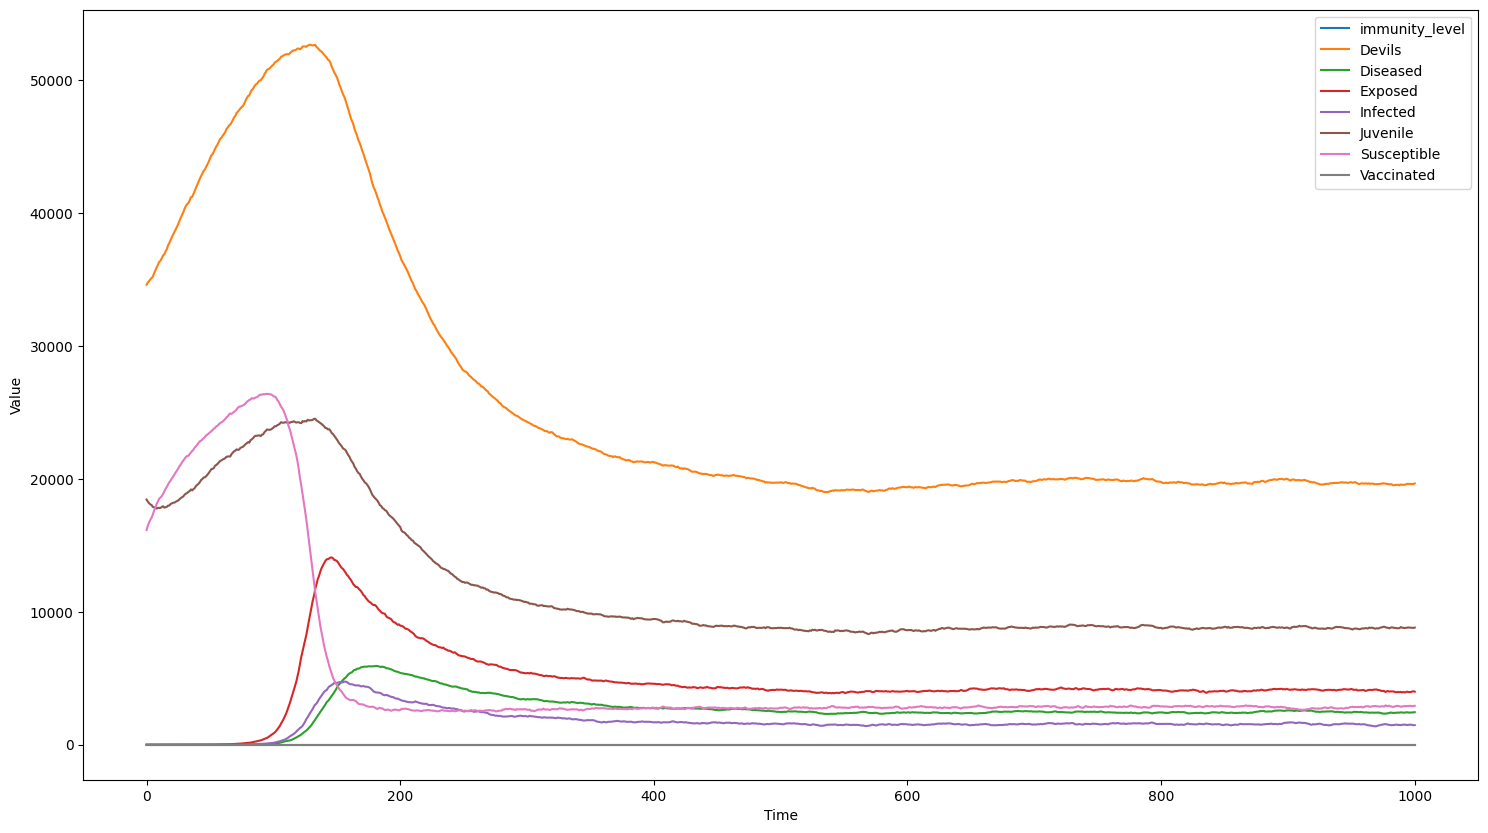

In [9]:
results = run_simulation()
results.plot()

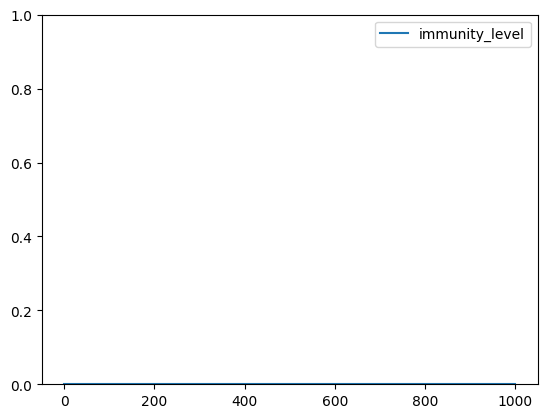

In [10]:
plt.plot(results[0]['immunity_level'], label="immunity_level")
plt.ylim(0,1)
plt.legend()

# Visualization

In [11]:
def plot(results, start=0, alpha=0.3, plot_observed=False, end_time=1000):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(results.model.listOfParameters['DFTD_introduction'].value)
    immunity_start = int(results.variables['immunity_start'])
    vaccine_start = int(results.variables['vaccine_start'])
    cull_start = int(results.variables['cull_start'])
    
    vaccine_end = vaccine_start + 12*int(results.variables['vacc_program_length'])
    cull_end = cull_start + 12*int(results.variables['cull_program_length'])
    
    spec_list = [results['Juvenile'], results['Susceptible'], results['Exposed'],
                 results['Infected'], results['Diseased'], results['Vaccinated']]
    total_devils = np.add.reduce(spec_list)
    x = results['time'][start:end_time]
    text_offset = (results['time'].size - start) / 601

    
    fig, ax1 = plt.subplots(figsize=[15, 8])    
    
    plt.title("Tasmanian Devil Population with DFTD", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[start]}", fontsize=14)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax1.plot(x, total_devils[start:end_time], color='blue', label='Total Devils')
    ax1.plot(x, results['Juvenile'][start:end_time], color='purple', alpha=alpha, label='Juvenile')
    ax1.plot(x, results['Susceptible'][start:end_time], color='green', alpha=alpha, label='Susceptible')
    ax1.plot(x, results['Exposed'][start:end_time], color='magenta', alpha=alpha, label='Exposed')
    ax1.plot(x, results['Infected'][start:end_time], color='red', alpha=alpha, label='Infected')
    ax1.plot(x, results['Diseased'][start:end_time], color='brown', alpha=alpha, label='Diseased')
    ax1.set_ylim([-3000, carry_cap])

    if plot_observed:
        plt.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed') 
    
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start-10*text_offset, 45000, "DFTD Introduced", rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start+3*text_offset, 48000, dates[dftd_start], rotation="vertical", color="black", fontsize=12)
    
    # immunity
    if (results[0]['immunity_level'] > 0).any():
        # immunity start
        ax1.plot([immunity_start, immunity_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(immunity_start-10*text_offset, 39000,
                 "Start immunity: "+dates[immunity_start], rotation="vertical", color="black", fontsize=12)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(x, results['immunity_level'][start:end_time], '--r', alpha=0.3, label="immunity")
        ax2.set_ylim(0,100)
        #ax2.set_yticks(ax2.get_yticks(),color="red")
        ax2.set_ylabel("Immunity %", color="red")
        ax2.tick_params(axis='y',labelcolor="red")

    
    # vax
    if vaccine_start < vaccine_end:
        ax1.plot(x, results['Vaccinated'][start:end_time], color='cyan', alpha=alpha, label='Vaccinated')
        ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap-3000], '--k', alpha=0.3)
        ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap-3000], '--k', alpha=0.3)    
        ax1.plot([vaccine_start, vaccine_end], [carry_cap-3000, carry_cap-3000],'--k', alpha=0.3)
        ax1.text(vaccine_start, carry_cap-2300, "Vaccine: "+dates[vaccine_start]+"-"+dates[vaccine_end], color="black", fontsize=12)

    # cull
    if cull_start < cull_end:
        ax1.plot([cull_start, cull_start], [-3000, carry_cap-8000], '--k', alpha=0.3)
        ax1.plot([cull_end, cull_end], [-3000, carry_cap-8000], '--k', alpha=0.3)
        ax1.plot([cull_start, cull_end], [carry_cap-8000, carry_cap-8000],'--k', alpha=0.3)
        ax1.text(cull_start, carry_cap-7300, "Culling: "+dates[cull_start]+"-"+dates[cull_end], color="black", fontsize=12)

    ax1.set_ylim(0,carry_cap)
    ax1.set_xlim(0,end_time)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()
    #return carry_cap


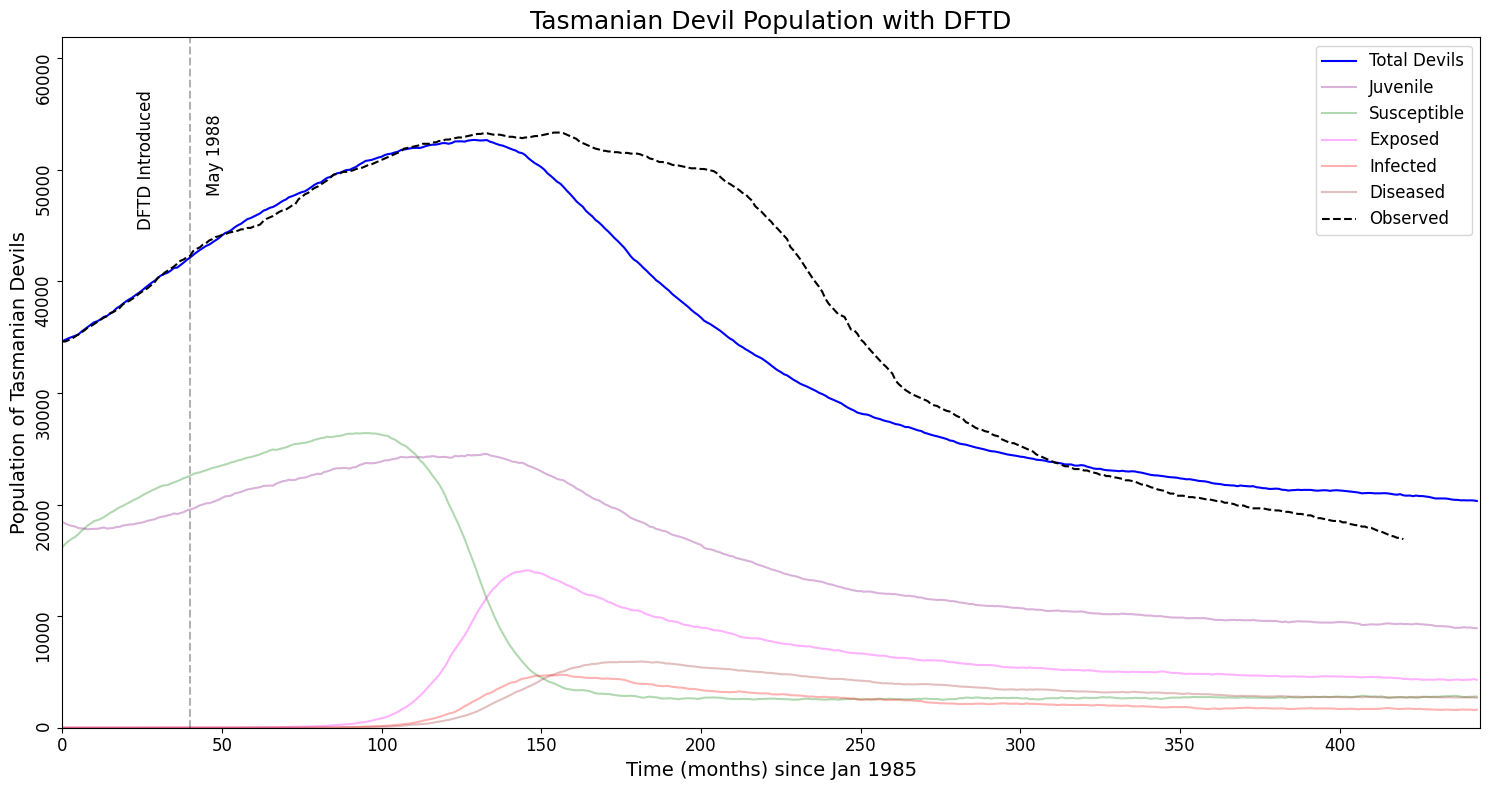

In [12]:
plot(results, plot_observed=True, end_time=444)

In [13]:
results_v = run_simulation({'vacc_program_length':10})

	vacc_program_length=10
simulation complete in 14.37s


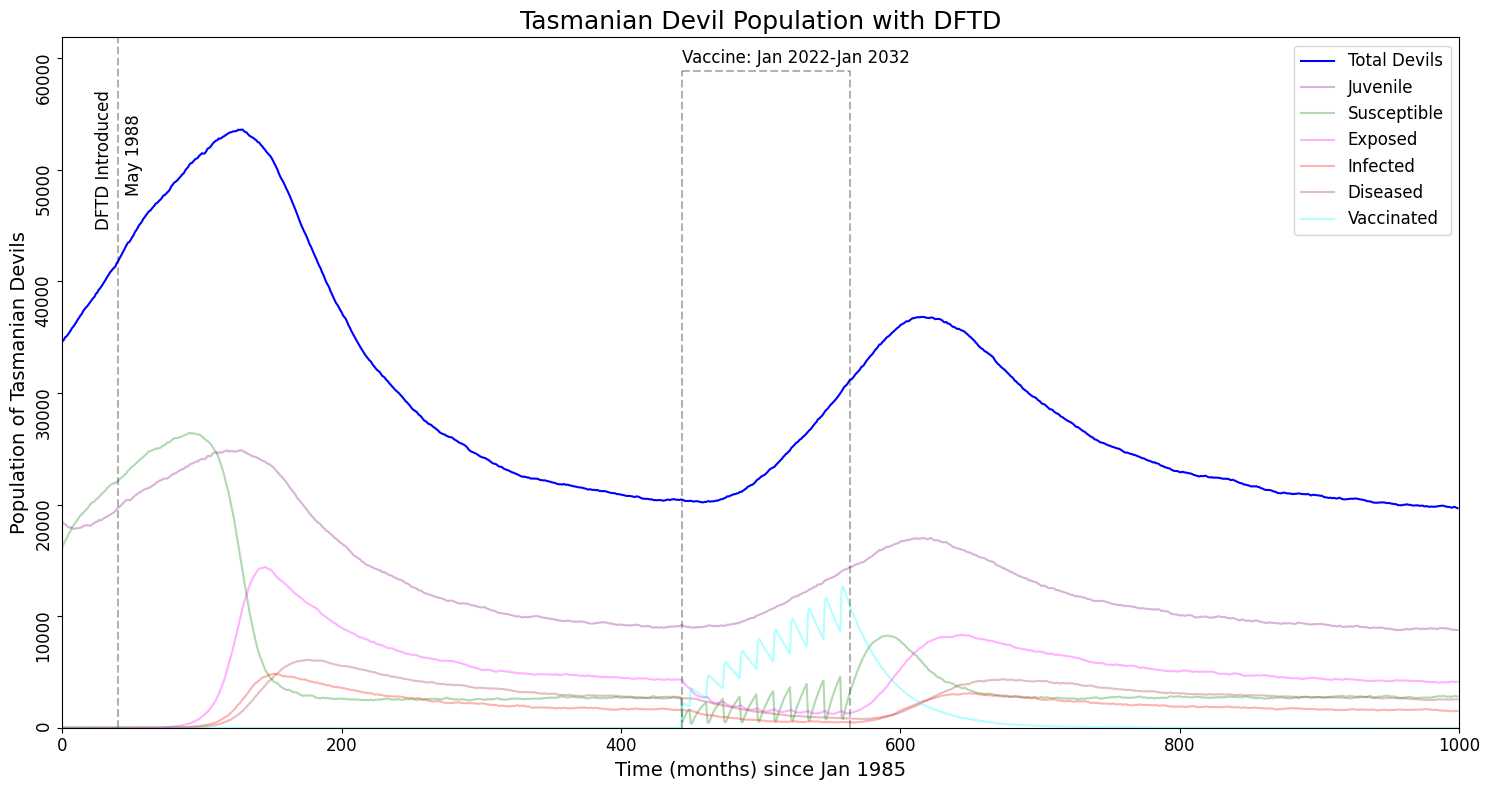

In [14]:
plot(results_v)

In [15]:
results_c = run_simulation({'cull_program_length':10})

	cull_program_length=10
simulation complete in 14.13s


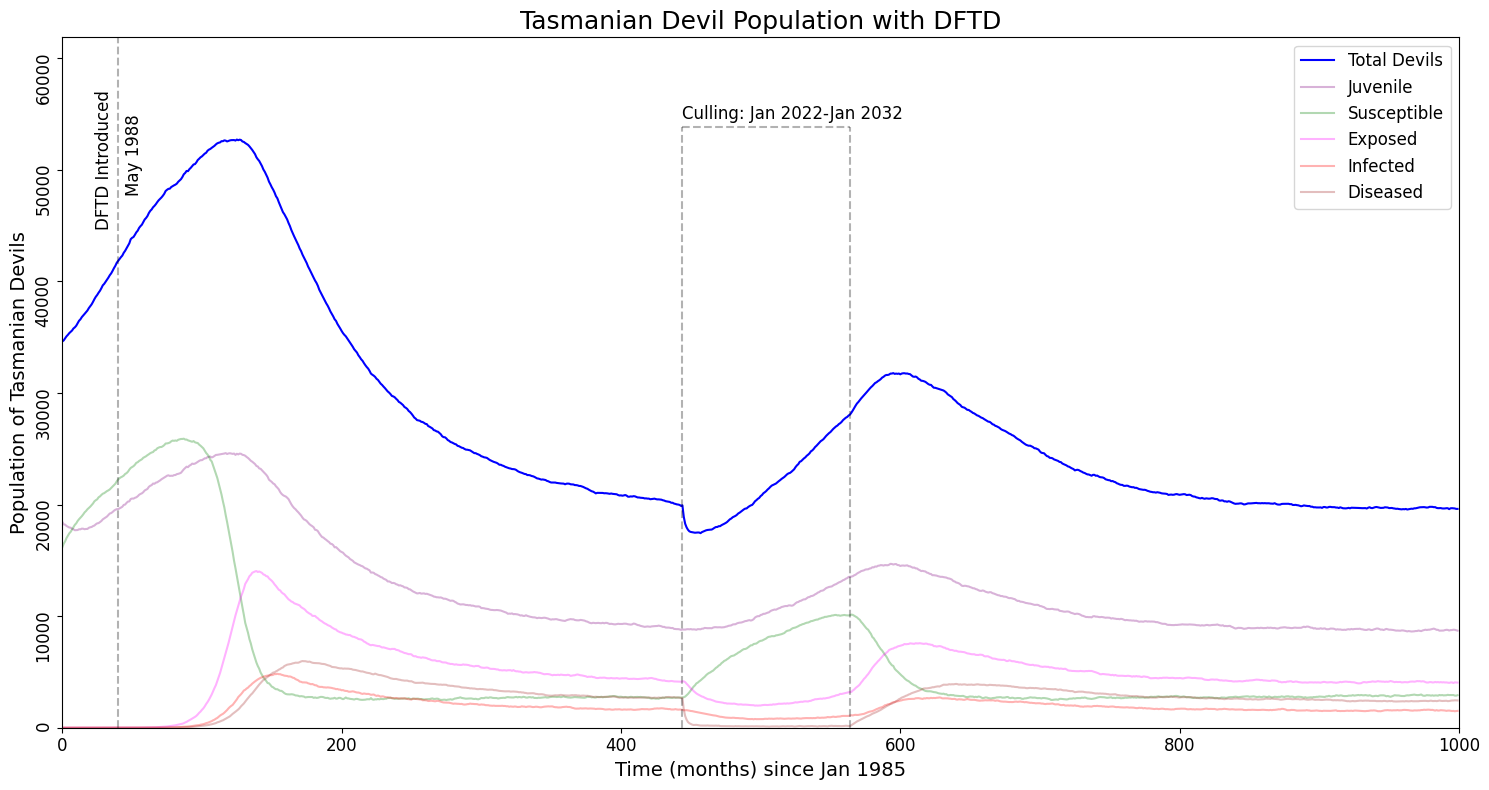

In [16]:
plot(results_c)

In [17]:
results_i = run_simulation(
    {'immunity_start':444,
     "immunity_growth_rate": 0.01,
    "immunity_max_level": 100,})

	immunity_start=444
	immunity_growth_rate=0.01
	immunity_max_level=100
simulation complete in 14.43s


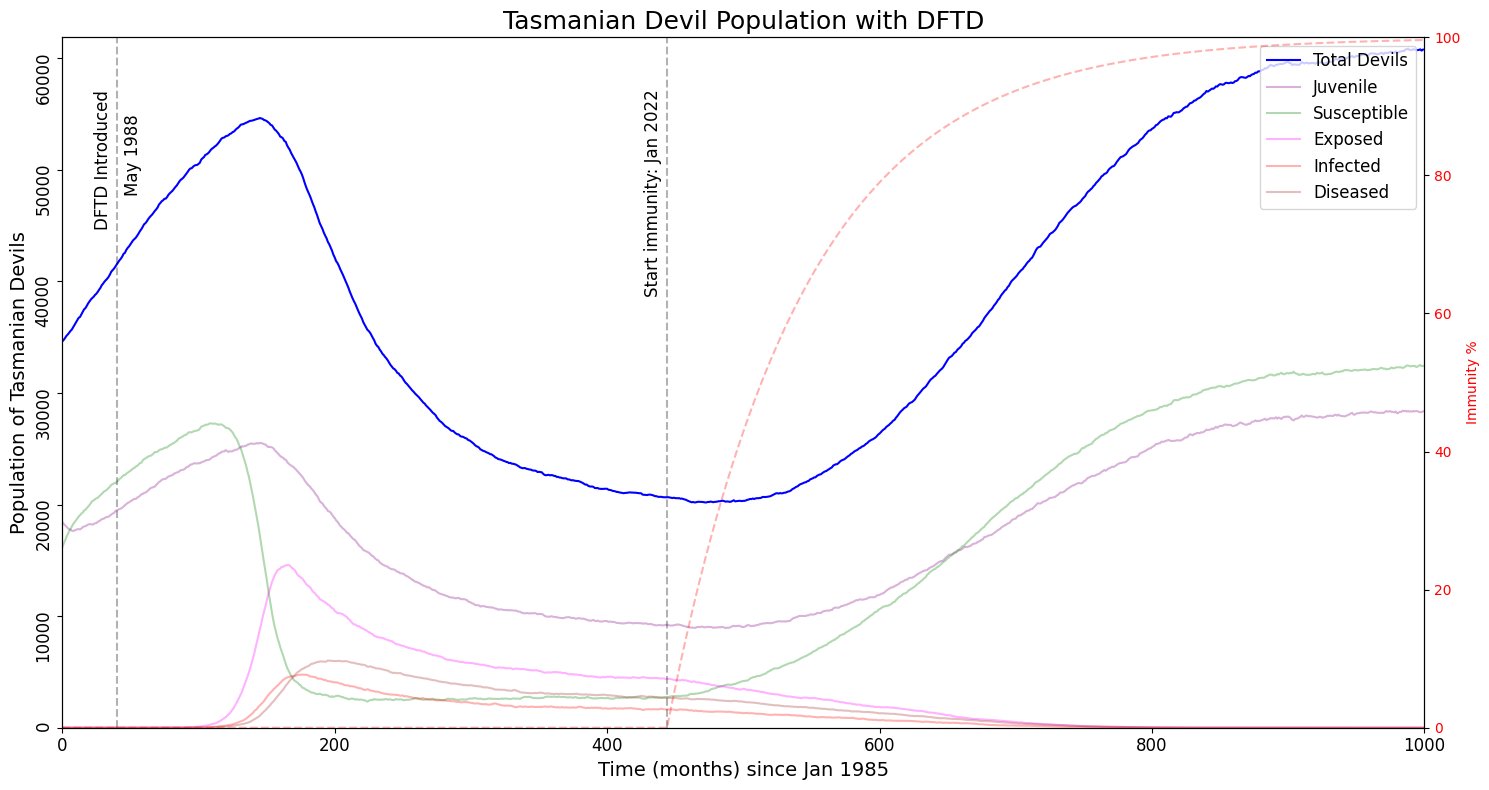

In [18]:
plot(results_i)

In [19]:
results_i2 = run_simulation(
    {'immunity_start':444,
     "immunity_growth_rate": 0.02,
    "immunity_max_level": 70,})


	immunity_start=444
	immunity_growth_rate=0.02
	immunity_max_level=70
simulation complete in 14.71s


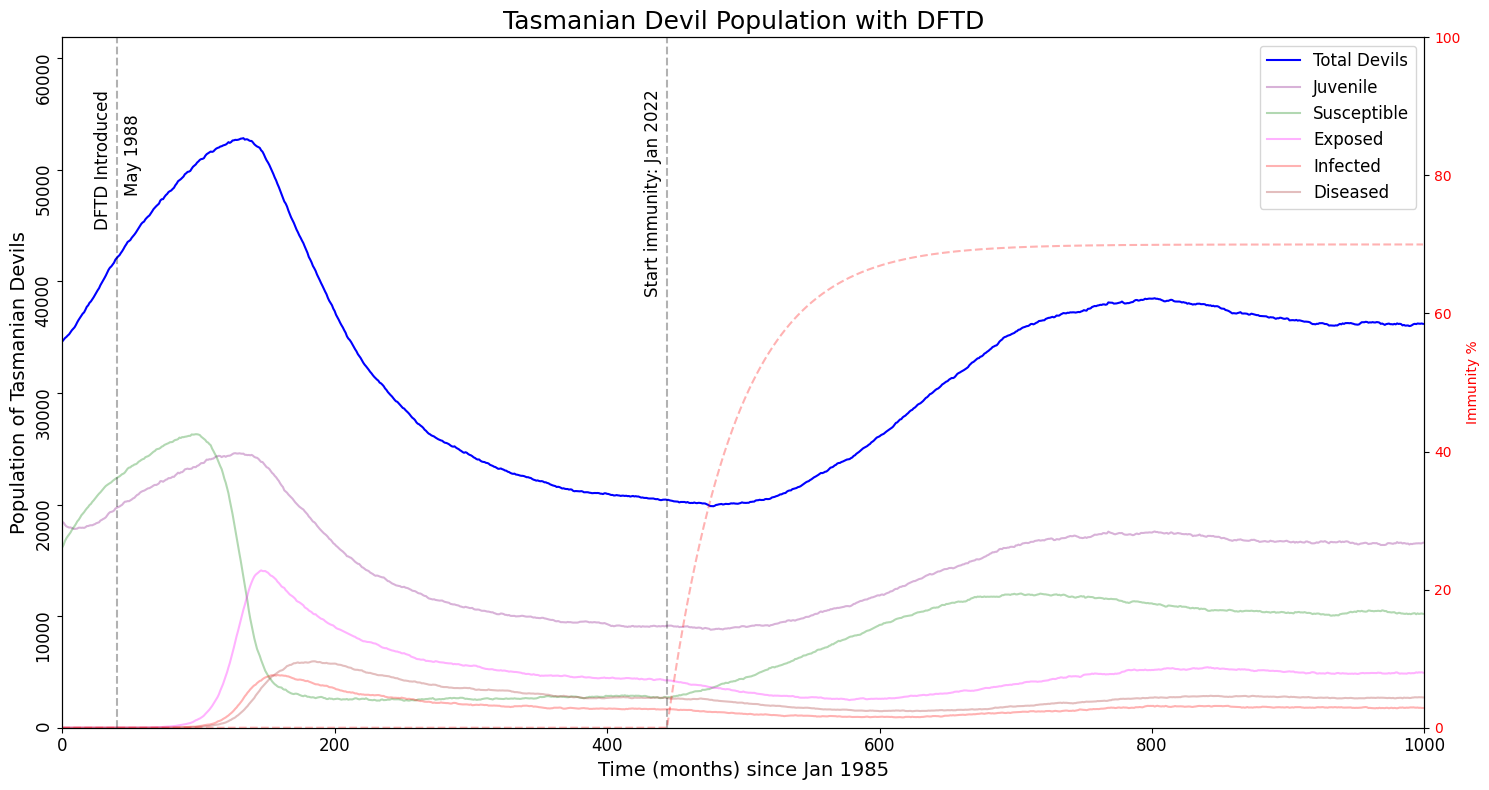

In [20]:
plot(results_i2)

	immunity_start=444
	immunity_growth_rate=0.0075
	immunity_max_level=70
simulation complete in 14.61s


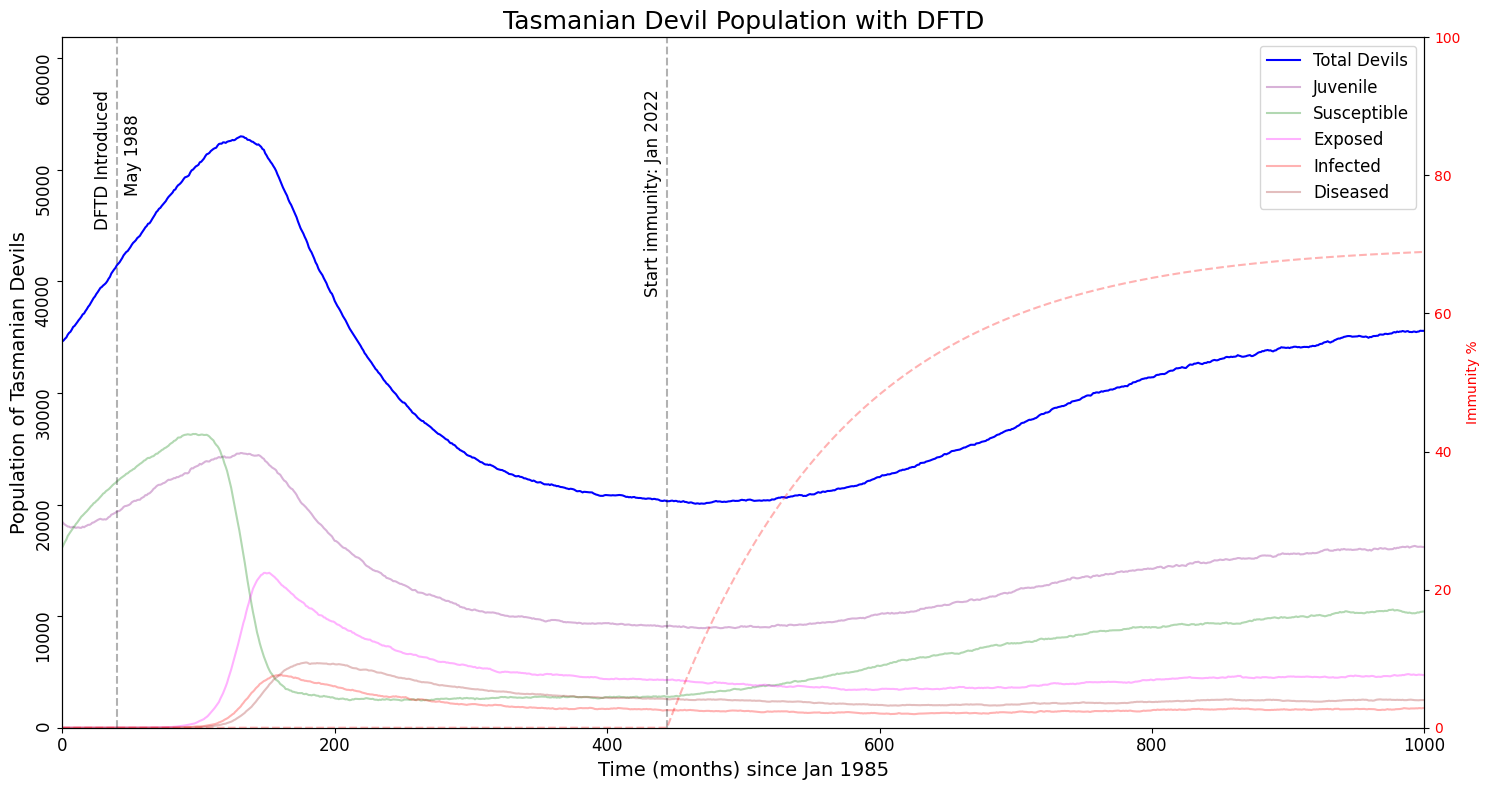

In [21]:
plot(run_simulation(
    {'immunity_start':444,
     "immunity_growth_rate": 0.0075,
    "immunity_max_level": 70,})
    )

In [28]:
results_vci = run_simulation({
     'vacc_program_length':20, 
     'cull_program_length':20,
     'immunity_start':444,
     "immunity_growth_rate": 0.0075,
     "immunity_max_level": 70,
    })

	vacc_program_length=20
	cull_program_length=20
	immunity_start=444
	immunity_growth_rate=0.0075
	immunity_max_level=70
simulation complete in 26.72s


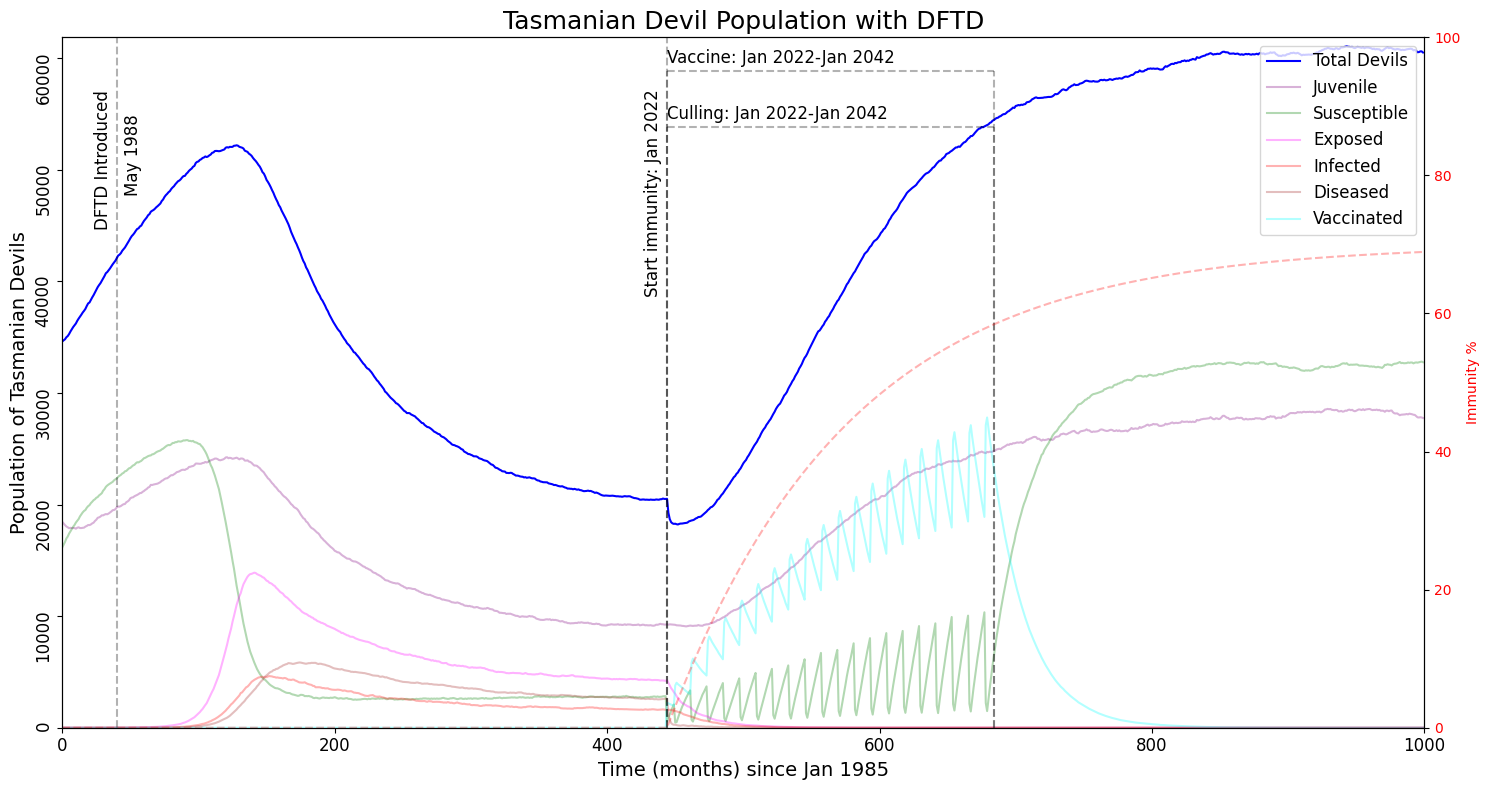

In [29]:
plot(results_vci)

In [32]:
results_vc2 = run_simulation({
     'vacc_program_length':20, 
     'cull_program_length':20,
    })

	vacc_program_length=20
	cull_program_length=20
simulation complete in 22.27s


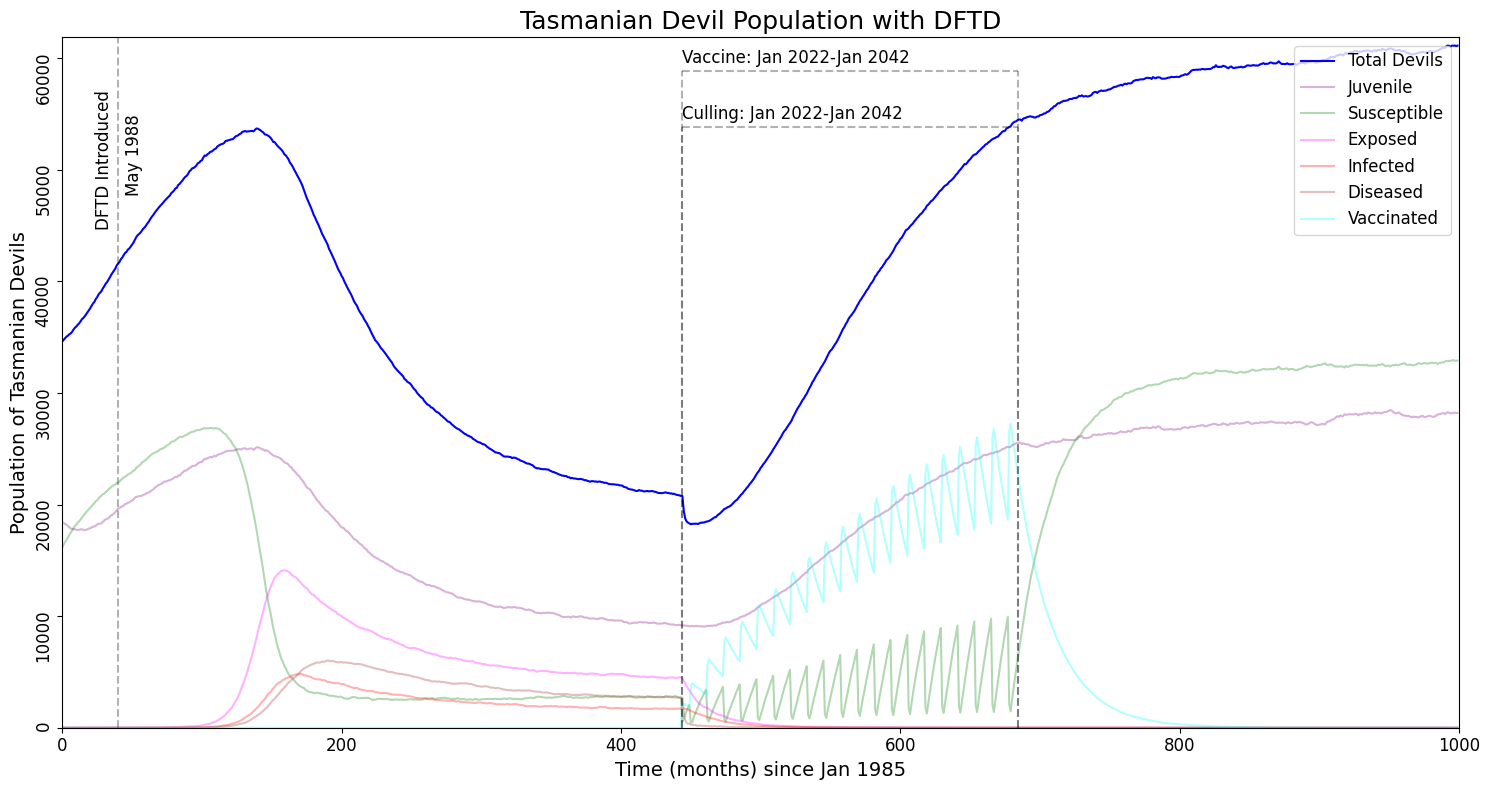

In [33]:
plot(results_vc2)